In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import wandb
from wandb.keras import WandbCallback
import os
import re
import sentencepiece as spm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [2]:
train_data_path ="aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [3]:
df=train_data

In [4]:
df['class'] = df['class'].replace('협박 대화', 0, inplace=False)
df['class'] = df['class'].replace('갈취 대화', 1, inplace=False)
df['class'] = df['class'].replace('직장 내 괴롭힘 대화', 2, inplace=False)
df['class'] = df['class'].replace('기타 괴롭힘 대화', 3, inplace=False)

In [5]:
df[df.duplicated('conversation')]

,idx,class,conversation
392,392,3,병신이 아이스크림 먹게 돼 있냐?\n난 먹으면 안 돼? 그만 좀 해.\n당연히 안 ...
523,523,2,과장님. 저 이번에 휴가 좀 갔다와도 되겠습니까.?\n휴가? 왜??\n좀 쉬다가 오...
789,789,3,야 얘 이 쪽 손가락 세 개밖에 없다\n엥 손가락이 세개밖에 없을 수가 있어?\n봐...
824,824,3,이야 내동생 여자친구한테 편지쓰네?\n 아 형 돌려줘.\n 어디보자. 사랑하는 여친...
869,869,2,지현씨 나 소개팅 좀 시켜줘봐\n네? 저 주변에 아는 사람이 없어서요\n아 상사라 ...
...,...,...,...
3797,3797,3,너 이번 방학 때 쌍꺼풀 수술 하고왔지?\n아닌데?\n아니긴 뭐가 아니야. 눈이 이...
3798,3798,3,안녕하세요 지금 먹방 촬영중인데 촬영가능할까요?\n안돼요\n한번만 안될까요?\n안돼...
3855,3855,3,그 소문 진짜야? 너가 다른 애들 뒷담화하고 다녔다며?\n응? 나 그런 적 없는데?...
3874,3874,3,야 니 왤캐 못생겼냐?\n뭐라그랬냐?\n으 나 보고 말하지마 니 얼굴보면 토나올거 ...


In [7]:
df = df.drop_duplicates('conversation')
df

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,3,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,1,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,2,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,1,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [8]:
def clean_sentence(text):
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z\s]', '', text)  # 한글, 영문, 공백 제외한 문자 제거
    text = text.strip()  # 양 끝 공백 제거
    clean_sentence = text.strip()       
    
    return clean_sentence


In [9]:
df['cleaned_conversation'] = df['conversation'].apply(clean_sentence)
df['cleaned_conversation'] = df['cleaned_conversation'].str.replace('\n', ' ')

In [10]:
df

,idx,class,conversation,cleaned_conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 시 분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 얘기한...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...,...,...
3945,3945,3,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...,준하야 넌 대가리가 왜이렇게 크냐 내 머리가 뭐 밥먹으면 대가리만 크냐 너는 아니 ...
3946,3946,1,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...,내가 지금 너 아들 김길준 데리고 있어 살리고 싶으면 계좌에 억만 보내 예 선생님 ...
3947,3947,2,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...,나는 씨 같은 사람 보면 참 신기하더라 어떻게 저렇게 살지 왜 그래 들리겠어 들리라...
3948,3948,1,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...,누구맘대로 여기서 장사하래 이게 무슨일입니까 남의 구역에서 장사하려면 자릿세를 내야...


In [11]:
from konlpy.tag import Okt, Mecab
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import operator

# 한국어 형태소 분석기 초기화
okt = Okt()
mecab = Mecab()

def tokenize(text):
    tokens = okt.morphs(text)  # 문장을 형태소 단위로 분리
    return tokens

# 불용어 리스트 정의
stop_words = [
    "은", "는", "이", "가", "을", "를", "으로", "에", "에서",
    "하다", "하는", "된", "나", "고", "와", "과", "너무", "있는", "같은", 
    "하는", "것", "그", "그리고", "하는", "하는", "말", "생각", "다", "그런",
    "저", "제", "네", "들", "이다", "입니다", "한다", "합니다", "돼", "이런",
    "저런", "그런", "할", "수z", "있는", "또는", "아니", "합니다", "있다", "왜",
    "여기", "저기", "그렇게", "그러니까", "뭐", "하나", "때", "수", "등", "아주",
    "너", "내", "야", "안", "니", "도"
    # 추가적인 불용어 단어 추가 가능
]

def return_words(corpus):
    # filter stop words
    vect = CountVectorizer(tokenizer=tokenize, stop_words=stopwords, analyzer='word')
    bow_vect = vect.fit_transform(corpus)
    word_list = vect.get_feature_names()  # 어떤 단어들이 들어가있는지 확인
    count_list = bow_vect.toarray().sum(axis=0)  # 인덱스순으로 몇개의 단어가 있는지
    word_count_dict = dict(zip(word_list, count_list))  # word, count를 key value로 묶는 것

    # 빈도수가 높은 순으로 정렬
    sorted_word_count = sorted(word_count_dict.items(), key=operator.itemgetter(1), reverse=True)
    print(sorted_word_count)

In [12]:
df['okt_tk'] = df['cleaned_conversation'].apply(tokenize)

In [13]:
def tokenize_mecab(text):
    tokens = mecab.morphs(text)  # 문장을 형태소 단위로 분리
    return tokens

df['mecab_tk'] = df['cleaned_conversation'].apply(tokenize_mecab)

In [14]:
df

,idx,class,conversation,cleaned_conversation,okt_tk,mecab_tk
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자...,"[지금, 너, 스스로, 를, 죽여, 달라, 고, 애원, 하는, 것, 인가, 아닙니다...","[지금, 너, 스스로, 를, 죽여, 달, 라고, 애원, 하, 는, 것, 인가, 아닙..."
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 시 분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 얘기한...,"[길동, 경찰서, 입니다, 시, 분, 마트, 에, 폭발물, 을, 설치, 할거다, 네...","[길동, 경찰서, 입니다, 시, 분, 마트, 에, 폭발물, 을, 설치, 할, 거, ..."
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...,"[너, 되게, 귀여운거, 알, 지, 나, 보다, 작은, 남자, 는, 첨, 봤어, 그...","[너, 되게, 귀여운, 거, 알, 지, 나, 보다, 작, 은, 남자, 는, 첨, 봤..."
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...,"[어이, 거기, 예, 너, 말, 이야, 너, 이리, 오라, 고, 무슨, 일, 너, ...","[어, 이, 거기, 예, 너, 말, 이, 야, 너, 이리, 오, 라고, 무슨, 일,..."
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...,"[저기, 요, 혹시, 날, 이, 너무, 뜨겁잖아요, 저희, 회사, 에서, 이, 선크...","[저기, 요, 혹시, 날, 이, 너무, 뜨겁, 잖아요, 저희, 회사, 에서, 이, ..."
...,...,...,...,...,...,...
3945,3945,3,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...,준하야 넌 대가리가 왜이렇게 크냐 내 머리가 뭐 밥먹으면 대가리만 크냐 너는 아니 ...,"[준, 하야, 넌, 대가리, 가, 왜, 이렇게, 크냐, 내, 머리, 가, 뭐, 밥,...","[준, 하, 야, 넌, 대가리, 가, 왜, 이렇게, 크, 냐, 내, 머리, 가, 뭐..."
3946,3946,1,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...,내가 지금 너 아들 김길준 데리고 있어 살리고 싶으면 계좌에 억만 보내 예 선생님 ...,"[내, 가, 지금, 너, 아들, 김길준, 데리, 고, 있어, 살리고, 싶으면, 계좌...","[내, 가, 지금, 너, 아들, 김길준, 데리, 고, 있, 어, 살리, 고, 싶, ..."
3947,3947,2,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...,나는 씨 같은 사람 보면 참 신기하더라 어떻게 저렇게 살지 왜 그래 들리겠어 들리라...,"[나, 는, 씨, 같은, 사람, 보면, 참, 신기하더라, 어떻게, 저렇게, 살, 지...","[나, 는, 씨, 같, 은, 사람, 보, 면, 참, 신기, 하, 더라, 어떻게, 저..."
3948,3948,1,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...,누구맘대로 여기서 장사하래 이게 무슨일입니까 남의 구역에서 장사하려면 자릿세를 내야...,"[누구, 맘대로, 여기, 서, 장사, 하래, 이, 게, 무슨, 일, 입, 니까, 남...","[누구, 맘대로, 여기, 서, 장사, 하, 래, 이게, 무슨, 일, 입니까, 남, ..."


In [16]:
#500자 이상 제거 
filtered_df = df[df['cleaned_conversation'].apply(len) <= 500]

In [17]:
filtered_df

,idx,class,conversation,cleaned_conversation,okt_tk,mecab_tk
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자...,"[지금, 너, 스스로, 를, 죽여, 달라, 고, 애원, 하는, 것, 인가, 아닙니다...","[지금, 너, 스스로, 를, 죽여, 달, 라고, 애원, 하, 는, 것, 인가, 아닙..."
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 시 분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 얘기한...,"[길동, 경찰서, 입니다, 시, 분, 마트, 에, 폭발물, 을, 설치, 할거다, 네...","[길동, 경찰서, 입니다, 시, 분, 마트, 에, 폭발물, 을, 설치, 할, 거, ..."
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...,"[너, 되게, 귀여운거, 알, 지, 나, 보다, 작은, 남자, 는, 첨, 봤어, 그...","[너, 되게, 귀여운, 거, 알, 지, 나, 보다, 작, 은, 남자, 는, 첨, 봤..."
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...,"[어이, 거기, 예, 너, 말, 이야, 너, 이리, 오라, 고, 무슨, 일, 너, ...","[어, 이, 거기, 예, 너, 말, 이, 야, 너, 이리, 오, 라고, 무슨, 일,..."
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...,"[저기, 요, 혹시, 날, 이, 너무, 뜨겁잖아요, 저희, 회사, 에서, 이, 선크...","[저기, 요, 혹시, 날, 이, 너무, 뜨겁, 잖아요, 저희, 회사, 에서, 이, ..."
...,...,...,...,...,...,...
3945,3945,3,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...,준하야 넌 대가리가 왜이렇게 크냐 내 머리가 뭐 밥먹으면 대가리만 크냐 너는 아니 ...,"[준, 하야, 넌, 대가리, 가, 왜, 이렇게, 크냐, 내, 머리, 가, 뭐, 밥,...","[준, 하, 야, 넌, 대가리, 가, 왜, 이렇게, 크, 냐, 내, 머리, 가, 뭐..."
3946,3946,1,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...,내가 지금 너 아들 김길준 데리고 있어 살리고 싶으면 계좌에 억만 보내 예 선생님 ...,"[내, 가, 지금, 너, 아들, 김길준, 데리, 고, 있어, 살리고, 싶으면, 계좌...","[내, 가, 지금, 너, 아들, 김길준, 데리, 고, 있, 어, 살리, 고, 싶, ..."
3947,3947,2,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...,나는 씨 같은 사람 보면 참 신기하더라 어떻게 저렇게 살지 왜 그래 들리겠어 들리라...,"[나, 는, 씨, 같은, 사람, 보면, 참, 신기하더라, 어떻게, 저렇게, 살, 지...","[나, 는, 씨, 같, 은, 사람, 보, 면, 참, 신기, 하, 더라, 어떻게, 저..."
3948,3948,1,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...,누구맘대로 여기서 장사하래 이게 무슨일입니까 남의 구역에서 장사하려면 자릿세를 내야...,"[누구, 맘대로, 여기, 서, 장사, 하래, 이, 게, 무슨, 일, 입, 니까, 남...","[누구, 맘대로, 여기, 서, 장사, 하, 래, 이게, 무슨, 일, 입니까, 남, ..."


# Sentencepiece

In [31]:
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):

    with open(f"{lang}_corpus.txt", "w") as f:
        for sentence in corpus:
            f.write(sentence + "\n")
    
    model_prefix = f"{lang}_tokenizer"
    
    # Train SentencePiece tokenizer
    spm.SentencePieceTrainer.train(
        f"--input={lang}_corpus.txt --model_prefix={model_prefix} --vocab_size={vocab_size}" + 
        f" --pad_id={pad_id} --pad_piece=[PAD]" +
        f" --unk_id={unk_id} --unk_piece=[UNK]" +
        f" --bos_id={bos_id} --bos_piece=[BOS]" +
        f" --eos_id={eos_id} --eos_piece=[EOS]" +
        " --model_type=unigram --max_sentence_length=999999")

    # Load tokenizer
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{model_prefix}.model")
    
    return tokenizer

In [32]:
sentence_train = filtered_df['cleaned_conversation']
y_train = filtered_df['class']

In [33]:
VOCAB_SIZE = 20000
tokenizer = generate_tokenizer(sentence_train, VOCAB_SIZE, 'ko')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=ko_corpus.txt --model_prefix=ko_tokenizer --vocab_size=20000 --pad_id=0 --pad_piece=[PAD] --unk_id=3 --unk_piece=[UNK] --bos_id=1 --bos_piece=[BOS] --eos_id=2 --eos_piece=[EOS] --model_type=unigram --max_sentence_length=999999
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_tokenizer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extreme

In [34]:
# 패딩처리
padding_train = tf.keras.preprocessing.sequence.pad_sequences(
    [tokenizer.encode_as_ids(sentence) for sentence in sentence_train],
    padding='post'
)

In [35]:
#train test split 이용하여 데이터 나누기 
X_train, X_val, y_train, y_val = train_test_split(padding_train,y_train, test_size = 0.20, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(3000, 191) (3000,)
(750, 191) (750,)


In [39]:
#모델 만들기 
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 256

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1])) #X_train.shape[1]
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 191, 256)          12800000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 191, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               142800    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 12,943,204
Trainable params: 12,943,204
Non-trainable params: 0
_________________________________________________________________


In [40]:
#모델 학습
epochs = 100
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks= [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/100
43/43 [==============================] - 47s 720ms/step - loss: 1.3916 - accuracy: 0.2433 - val_loss: 1.3852 - val_accuracy: 0.2500
Epoch 2/100
43/43 [==============================] - 30s 704ms/step - loss: 1.3877 - accuracy: 0.2552 - val_loss: 1.3851 - val_accuracy: 0.2900
Epoch 3/100
43/43 [==============================] - 30s 700ms/step - loss: 1.3872 - accuracy: 0.2541 - val_loss: 1.3825 - val_accuracy: 0.2900
Epoch 4/100
43/43 [==============================] - 30s 698ms/step - loss: 1.3876 - accuracy: 0.2478 - val_loss: 1.3850 - val_accuracy: 0.2867
Epoch 5/100
43/43 [==============================] - 30s 700ms/step - loss: 1.3859 - accuracy: 0.2485 - val_loss: 1.3830 - val_accuracy: 0.2900
Epoch 6/100
43/43 [==============================] - 30s 704ms/step - loss: 1.3866 - accuracy: 0.2585 - val_loss: 1.3837 - val_accuracy: 0.2900


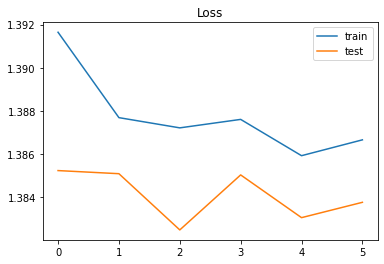

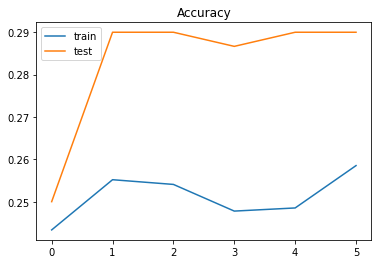

In [41]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
# OKT

In [19]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token="<OOV>")

In [24]:
tokenizer.fit_on_texts(filtered_df['okt_tk'])
sequences = tokenizer.texts_to_sequences(filtered_df['okt_tk'])
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')

In [43]:
padded_sequences.shape

(3750, 199)

In [46]:
y_train = filtered_df['class']

In [47]:
#train test split 이용하여 데이터 나누기 
X_train_o, X_val_o, y_train_o, y_val_o = train_test_split(padded_sequences, y_train, test_size = 0.20, random_state = 42)
print(X_train_o.shape,y_train_o.shape)
print(X_val_o.shape,y_val_o.shape)

(3000, 199) (3000,)
(750, 199) (750,)


In [48]:
#모델 만들기 
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 256

model_o = Sequential()
model_o.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train_o.shape[1])) #X_train.shape[1]
model_o.add(SpatialDropout1D(0.3))
model_o.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_o.add(Dense(4, activation='softmax'))


model_o.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_o.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 191, 256)          12800000  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 191, 256)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               142800    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 12,943,204
Trainable params: 12,943,204
Non-trainable params: 0
_________________________________________________________________


In [49]:
#모델 학습
epochs = 100
batch_size = 64

history_o = model_o.fit(X_train_o, y_train_o, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks= [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/100
43/43 [==============================] - 35s 739ms/step - loss: 1.3887 - accuracy: 0.2496 - val_loss: 1.3867 - val_accuracy: 0.2500
Epoch 2/100
43/43 [==============================] - 31s 732ms/step - loss: 1.3865 - accuracy: 0.2619 - val_loss: 1.3845 - val_accuracy: 0.2900
Epoch 3/100
43/43 [==============================] - 31s 731ms/step - loss: 1.3879 - accuracy: 0.2452 - val_loss: 1.3839 - val_accuracy: 0.2900
Epoch 4/100
43/43 [==============================] - 31s 726ms/step - loss: 1.3863 - accuracy: 0.2589 - val_loss: 1.3857 - val_accuracy: 0.2300
Epoch 5/100
43/43 [==============================] - 31s 729ms/step - loss: 1.3857 - accuracy: 0.2596 - val_loss: 1.3846 - val_accuracy: 0.2900
Epoch 6/100
43/43 [==============================] - 32s 738ms/step - loss: 1.3878 - accuracy: 0.2489 - val_loss: 1.3856 - val_accuracy: 0.2300


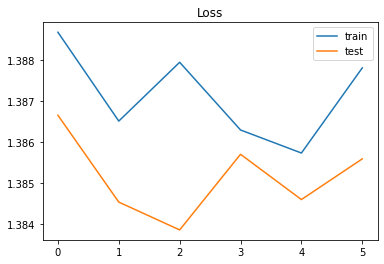

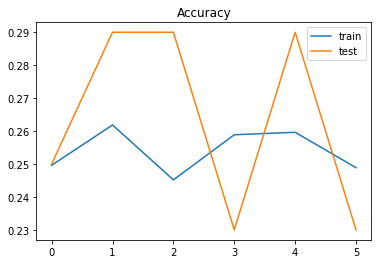

In [56]:
plt.title('Loss')
plt.plot(history_o.history['loss'], label='train')
plt.plot(history_o.history['val_loss'], label='test')
plt.legend()
plt.show();


plt.title('Accuracy')
plt.plot(history_o.history['accuracy'], label='train')
plt.plot(history_o.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
# mecab

In [26]:
tokenizer.fit_on_texts(filtered_df['mecab_tk'])
sequences1 = tokenizer.texts_to_sequences(filtered_df['mecab_tk'])
padded_sequences1 = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')

In [27]:
padded_sequences1

array([[   33,     4,  2068, ...,     0,     0,     0],
       [  373,  1320,   236, ...,     0,     0,     0],
       [    4,   802, 11354, ...,     0,     0,     0],
       ...,
       [    9,    16,    68, ...,     0,     0,     0],
       [  174,  1470,    65, ...,     0,     0,     0],
       [ 2273,  2993,     8, ...,     0,     0,     0]], dtype=int32)

In [51]:
y_train = filtered_df['class']

In [52]:
#train test split 이용하여 데이터 나누기 
X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(padded_sequences1, y_train, test_size = 0.20, random_state = 42)
print(X_train_m.shape,y_train_m.shape)
print(X_val_m.shape,y_val_m.shape)

(3000, 199) (3000,)
(750, 199) (750,)


In [53]:
#모델 만들기 
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 256

model_m = Sequential()
model_m.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train_m.shape[1])) #X_train.shape[1]
model_m.add(SpatialDropout1D(0.3))
model_m.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_m.add(Dense(4, activation='softmax'))


model_m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_m.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 199, 256)          12800000  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 199, 256)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               142800    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 404       
Total params: 12,943,204
Trainable params: 12,943,204
Non-trainable params: 0
_________________________________________________________________


In [54]:
#모델 학습
epochs = 100
batch_size = 64

history_m = model_m.fit(X_train_m, y_train_m, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks= [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/100
43/43 [==============================] - 34s 737ms/step - loss: 1.3880 - accuracy: 0.2526 - val_loss: 1.3868 - val_accuracy: 0.2900
Epoch 2/100
43/43 [==============================] - 31s 723ms/step - loss: 1.3866 - accuracy: 0.2593 - val_loss: 1.3855 - val_accuracy: 0.2500
Epoch 3/100
43/43 [==============================] - 31s 721ms/step - loss: 1.3864 - accuracy: 0.2548 - val_loss: 1.3832 - val_accuracy: 0.2900
Epoch 4/100
43/43 [==============================] - 31s 716ms/step - loss: 1.3862 - accuracy: 0.2504 - val_loss: 1.3850 - val_accuracy: 0.2900
Epoch 5/100
43/43 [==============================] - 31s 722ms/step - loss: 1.3865 - accuracy: 0.2515 - val_loss: 1.3843 - val_accuracy: 0.2900
Epoch 6/100
43/43 [==============================] - 31s 723ms/step - loss: 1.3851 - accuracy: 0.2648 - val_loss: 1.3835 - val_accuracy: 0.2900


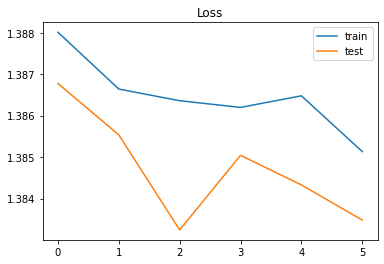

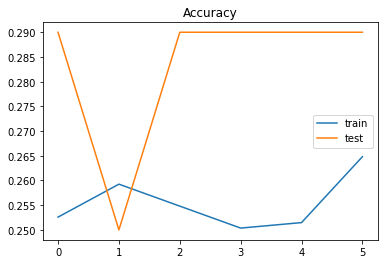

In [55]:
plt.title('Loss')
plt.plot(history_m.history['loss'], label='train')
plt.plot(history_m.history['val_loss'], label='test')
plt.legend()
plt.show();


plt.title('Accuracy')
plt.plot(history_m.history['accuracy'], label='train')
plt.plot(history_m.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [11]:
X_train[1]

'길동경찰서입니다 시 분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 얘기한다 장난전화 걸지 마시죠  시 분 마트에 폭발물이 터지면 다 죽는거야  장난전화는 업무방해죄에 해당됩니다 판단은 너에게 달려있다 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지 선생님 진정하세요 난 이야기했어 경고했다는 말이야'

In [12]:
#500자 이상 제거 
filtered_train = X_train[X_train.apply(len) <= 500]
filtered_y_train = df['class'][X_train.apply(len) <= 500]
print("원본데이터크기:", len(X_train))
print("전처리후데이터크기:", len(filtered_train))

원본데이터크기: 3846
전처리후데이터크기: 3750


In [13]:
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):

    with open(f"{lang}_corpus.txt", "w") as f:
        for sentence in corpus:
            f.write(sentence + "\n")
    
    model_prefix = f"{lang}_tokenizer"
    
    # Train SentencePiece tokenizer
    spm.SentencePieceTrainer.train(
        f"--input={lang}_corpus.txt --model_prefix={model_prefix} --vocab_size={vocab_size}" + 
        f" --pad_id={pad_id} --pad_piece=[PAD]" +
        f" --unk_id={unk_id} --unk_piece=[UNK]" +
        f" --bos_id={bos_id} --bos_piece=[BOS]" +
        f" --eos_id={eos_id} --eos_piece=[EOS]" +
        " --model_type=unigram --max_sentence_length=999999")

    # Load tokenizer
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{model_prefix}.model")
    
    return tokenizer

In [14]:
VOCAB_SIZE = 20000
tokenizer = generate_tokenizer(filtered_train, VOCAB_SIZE, 'ko')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=ko_corpus.txt --model_prefix=ko_tokenizer --vocab_size=20000 --pad_id=0 --pad_piece=[PAD] --unk_id=3 --unk_piece=[UNK] --bos_id=1 --bos_piece=[BOS] --eos_id=2 --eos_piece=[EOS] --model_type=unigram --max_sentence_length=999999
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_tokenizer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extreme

In [15]:
filtered_train

0       지금 너 스스로를 죽여달라고 애원하는 것인가  아닙니다 죄송합니다  죽을 거면 혼자...
1       길동경찰서입니다 시 분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 얘기한...
2       너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3       어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4       저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
                              ...                        
3945    준하야 넌 대가리가 왜이렇게 크냐 내 머리가 뭐 밥먹으면 대가리만 크냐 너는 아니 ...
3946    내가 지금 너 아들 김길준 데리고 있어 살리고 싶으면 계좌에 억만 보내 예 선생님 ...
3947    나는 씨 같은 사람 보면 참 신기하더라 어떻게 저렇게 살지 왜 그래 들리겠어 들리라...
3948    누구맘대로 여기서 장사하래 이게 무슨일입니까 남의 구역에서 장사하려면 자릿세를 내야...
3949    희정씨 네 주말에 시간이 넘쳐나나봐 갑자기 왜그러세요 손이 빤짝빤짝 네일했니 네 여...
Name: cleaned_conversation, Length: 3750, dtype: object

In [20]:
filtered_y_train

0       0
1       0
2       3
3       1
4       1
       ..
3945    3
3946    1
3947    2
3948    1
3949    2
Name: class, Length: 3750, dtype: int64

In [35]:
# 패딩처리
padding_train = tf.keras.preprocessing.sequence.pad_sequences(
    [tokenizer.encode_as_ids(sentence) for sentence in filtered_train],
    padding='post',maxlen = 100
)

In [36]:
print(padding_train)
print(len(padding_train))
print(padding_train.shape)

[[   29     5  2867 ...     0     0     0]
 [13561   230   640 ...     0     0     0]
 [    5   974 15784 ...     0     0     0]
 ...
 [  200  6111   508 ...  2992   121   323]
 [  234  6632   288 ...     0     0     0]
 [ 4901     9   600 ...     0     0     0]]
3750
(3750, 100)


In [37]:
#train test split 이용하여 데이터 나누기 
X_train, X_val, y_train, y_val = train_test_split(padding_train,filtered_y_train, test_size = 0.10, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(3375, 100) (3375,)
(375, 100) (375,)


In [38]:
wandb.login(key = 'fe058bb4c71545e98d9c876dc757c299294e4c77')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [42]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [43]:
def train():
    default_config = {
        "vocab" : 1000,
        "embeddings" : 64,
        "units_1" : 128,
        "units_2" : 128,
        "units_3" : 32,
        "class_num" : 4,
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config = default_config)
    config = wandb.config

    # Model

    model=keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.LSTM(units = config.units_1, return_sequences = True))
    model.add(keras.layers.LSTM(units = config.units_2))
    model.add(keras.layers.Dense(config.units_3, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.

    if config.optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = config.learning_rate)
    
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)

    # WandbCallback 함수는 후술합니다.
    
    model.fit(X_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_data = (X_val, y_val),
              callbacks = [WandbCallback()])
    
    test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=2)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [44]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'changtw90312',
                       project = 'in_zero')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: p81ogjp4
Sweep URL: https://wandb.ai/changtw90312/in_zero/sweeps/p81ogjp4


wandb: Agent Starting Run: qz7tc8sv with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.044751357575840846


Epoch 1/8
106/106 [==============================] - 5s 18ms/step - loss: 1.4494 - accuracy: 0.2631 - val_loss: 1.3861 - val_accuracy: 0.2453


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031632-qz7tc8sv/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031632-qz7tc8sv/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_031632-qz7tc8sv/files/model-best)... Done. 0.0s


Epoch 2/8
106/106 [==============================] - 1s 13ms/step - loss: 1.3882 - accuracy: 0.2596 - val_loss: 1.4044 - val_accuracy: 0.2320
Epoch 3/8
106/106 [==============================] - 1s 12ms/step - loss: 1.3895 - accuracy: 0.2530 - val_loss: 1.3895 - val_accuracy: 0.2640
Epoch 4/8
106/106 [==============================] - 1s 12ms/step - loss: 1.3877 - accuracy: 0.2516 - val_loss: 1.3949 - val_accuracy: 0.2320
Epoch 5/8
106/106 [==============================] - 1s 12ms/step - loss: 1.3884 - accuracy: 0.2560 - val_loss: 1.3862 - val_accuracy: 0.2640
Epoch 6/8
106/106 [==============================] - 1s 12ms/step - loss: 1.3884 - accuracy: 0.2536 - val_loss: 1.4006 - val_accuracy: 0.2320
Epoch 7/8
106/106 [==============================] - 1s 12ms/step - loss: 1.3872 - accuracy: 0.2625 - val_loss: 1.3893 - val_accuracy: 0.2587
Epoch 8/8
106/106 [==============================] - 1s 11ms/step - loss: 1.3868 - accuracy: 0.2578 - val_loss: 1.3966 - val_accuracy: 0.2453


accuracy,█▆▂▁▄▂█▅
epoch,▁▂▃▄▅▆▇█
loss,█▁▁▁▁▁▁▁
val_accuracy,▄▁█▁█▁▇▄
val_loss,▁█▂▄▁▇▂▅
accuracy,0.25778
best_epoch,0
best_val_loss,1.38607
epoch,7
loss,1.38681
val_accuracy,0.24533


wandb: Agent Starting Run: 0n0duvca with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.09174533362687325


Epoch 1/9
106/106 [==============================] - 4s 18ms/step - loss: 1.7207 - accuracy: 0.2379 - val_loss: 1.3881 - val_accuracy: 0.2427


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031704-0n0duvca/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031704-0n0duvca/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_031704-0n0duvca/files/model-best)... Done. 0.0s


Epoch 2/9
106/106 [==============================] - 1s 14ms/step - loss: 1.3959 - accuracy: 0.2409 - val_loss: 1.3940 - val_accuracy: 0.2453
Epoch 3/9
106/106 [==============================] - 1s 12ms/step - loss: 1.3883 - accuracy: 0.2634 - val_loss: 1.3902 - val_accuracy: 0.2640
Epoch 4/9
106/106 [==============================] - 1s 12ms/step - loss: 1.3948 - accuracy: 0.2439 - val_loss: 1.3914 - val_accuracy: 0.2453
Epoch 5/9
106/106 [==============================] - 1s 12ms/step - loss: 1.3910 - accuracy: 0.2388 - val_loss: 1.3913 - val_accuracy: 0.2453
Epoch 6/9
106/106 [==============================] - 1s 12ms/step - loss: 1.3948 - accuracy: 0.2483 - val_loss: 1.3977 - val_accuracy: 0.2320
Epoch 7/9
106/106 [==============================] - 1s 11ms/step - loss: 1.3910 - accuracy: 0.2560 - val_loss: 1.3982 - val_accuracy: 0.2640
Epoch 8/9
106/106 [==============================] - 1s 12ms/step - loss: 1.3936 - accuracy: 0.2634 - val_loss: 1.4209 - val_accuracy: 0.2320
Epoch 

accuracy,▁▂█▃▁▄▆█▆
epoch,▁▂▃▄▅▅▆▇█
loss,█▁▁▁▁▁▁▁▁
val_accuracy,▃▄█▄▄▁█▁▁
val_loss,▁▂▁▂▂▃▃█▆
accuracy,0.25689
best_epoch,0
best_val_loss,1.38811
epoch,8
loss,1.39229
val_accuracy,0.232


wandb: Agent Starting Run: wxqqtuv3 with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.04856228071271375


Epoch 1/8
106/106 [==============================] - 4s 17ms/step - loss: 1.4273 - accuracy: 0.2631 - val_loss: 1.3940 - val_accuracy: 0.2320


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031735-wxqqtuv3/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031735-wxqqtuv3/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_031735-wxqqtuv3/files/model-best)... Done. 0.0s


Epoch 2/8
106/106 [==============================] - 1s 13ms/step - loss: 1.3879 - accuracy: 0.2533 - val_loss: 1.3943 - val_accuracy: 0.2453
Epoch 3/8
106/106 [==============================] - 1s 11ms/step - loss: 1.3881 - accuracy: 0.2519 - val_loss: 1.3948 - val_accuracy: 0.2320
Epoch 4/8
106/106 [==============================] - 1s 11ms/step - loss: 1.3880 - accuracy: 0.2655 - val_loss: 1.3938 - val_accuracy: 0.2320


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031735-wxqqtuv3/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031735-wxqqtuv3/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_031735-wxqqtuv3/files/model-best)... Done. 0.0s


Epoch 5/8
106/106 [==============================] - 1s 13ms/step - loss: 1.3887 - accuracy: 0.2513 - val_loss: 1.3930 - val_accuracy: 0.2320


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031735-wxqqtuv3/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031735-wxqqtuv3/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_031735-wxqqtuv3/files/model-best)... Done. 0.0s


Epoch 6/8
106/106 [==============================] - 1s 13ms/step - loss: 1.3872 - accuracy: 0.2696 - val_loss: 1.3933 - val_accuracy: 0.2320
Epoch 7/8
106/106 [==============================] - 1s 12ms/step - loss: 1.3870 - accuracy: 0.2607 - val_loss: 1.3962 - val_accuracy: 0.2320
Epoch 8/8
106/106 [==============================] - 1s 12ms/step - loss: 1.3894 - accuracy: 0.2566 - val_loss: 1.3988 - val_accuracy: 0.2320


accuracy,▆▂▁▆▁█▅▃
epoch,▁▂▃▄▅▆▇█
loss,█▁▁▁▁▁▁▁
val_accuracy,▁█▁▁▁▁▁▁
val_loss,▂▃▃▂▁▁▅█
accuracy,0.25659
best_epoch,4
best_val_loss,1.39304
epoch,7
loss,1.38939
val_accuracy,0.232


wandb: Agent Starting Run: 7ymsa5c4 with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.0028149061327233894


Epoch 1/9
106/106 [==============================] - 5s 18ms/step - loss: 1.4144 - accuracy: 0.2818 - val_loss: 1.3909 - val_accuracy: 0.2587


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031820-7ymsa5c4/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031820-7ymsa5c4/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_031820-7ymsa5c4/files/model-best)... Done. 0.0s


Epoch 2/9
106/106 [==============================] - 1s 13ms/step - loss: 1.3953 - accuracy: 0.2483 - val_loss: 1.3989 - val_accuracy: 0.2587
Epoch 3/9
106/106 [==============================] - 1s 12ms/step - loss: 1.3867 - accuracy: 0.2554 - val_loss: 1.3881 - val_accuracy: 0.2320


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031820-7ymsa5c4/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031820-7ymsa5c4/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_031820-7ymsa5c4/files/model-best)... Done. 0.0s


Epoch 4/9
106/106 [==============================] - 1s 13ms/step - loss: 1.3853 - accuracy: 0.2655 - val_loss: 1.3886 - val_accuracy: 0.2320
Epoch 5/9
106/106 [==============================] - 1s 12ms/step - loss: 1.3850 - accuracy: 0.2655 - val_loss: 1.3892 - val_accuracy: 0.2320
Epoch 6/9
106/106 [==============================] - 1s 12ms/step - loss: 1.3853 - accuracy: 0.2655 - val_loss: 1.3893 - val_accuracy: 0.2320
Epoch 7/9
106/106 [==============================] - 1s 12ms/step - loss: 1.3849 - accuracy: 0.2655 - val_loss: 1.3896 - val_accuracy: 0.2320
Epoch 8/9
106/106 [==============================] - 1s 12ms/step - loss: 1.3849 - accuracy: 0.2655 - val_loss: 1.3896 - val_accuracy: 0.2320
Epoch 9/9
106/106 [==============================] - 1s 12ms/step - loss: 1.3851 - accuracy: 0.2655 - val_loss: 1.3899 - val_accuracy: 0.2320


accuracy,█▁▂▅▅▅▅▅▅
epoch,▁▂▃▄▅▅▆▇█
loss,█▃▁▁▁▁▁▁▁
val_accuracy,██▁▁▁▁▁▁▁
val_loss,▃█▁▁▂▂▂▂▂
accuracy,0.26548
best_epoch,2
best_val_loss,1.38808
epoch,8
loss,1.3851
val_accuracy,0.232


wandb: Agent Starting Run: 8wy8h052 with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.047149991972868295


Epoch 1/10
106/106 [==============================] - 4s 18ms/step - loss: 1.4237 - accuracy: 0.2527 - val_loss: 1.3956 - val_accuracy: 0.2453


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031912-8wy8h052/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031912-8wy8h052/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_031912-8wy8h052/files/model-best)... Done. 0.0s


Epoch 2/10
106/106 [==============================] - 1s 13ms/step - loss: 1.3904 - accuracy: 0.2521 - val_loss: 1.3923 - val_accuracy: 0.2320


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031912-8wy8h052/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031912-8wy8h052/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_031912-8wy8h052/files/model-best)... Done. 0.0s


Epoch 3/10
106/106 [==============================] - 1s 13ms/step - loss: 1.3889 - accuracy: 0.2373 - val_loss: 1.3975 - val_accuracy: 0.2640
Epoch 4/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3879 - accuracy: 0.2554 - val_loss: 1.3954 - val_accuracy: 0.2320
Epoch 5/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3878 - accuracy: 0.2670 - val_loss: 1.3868 - val_accuracy: 0.2640


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031912-8wy8h052/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031912-8wy8h052/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_031912-8wy8h052/files/model-best)... Done. 0.0s


Epoch 6/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3873 - accuracy: 0.2569 - val_loss: 1.4041 - val_accuracy: 0.2320
Epoch 7/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3887 - accuracy: 0.2504 - val_loss: 1.3872 - val_accuracy: 0.2320
Epoch 8/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3884 - accuracy: 0.2498 - val_loss: 1.3863 - val_accuracy: 0.2640


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031912-8wy8h052/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_031912-8wy8h052/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_031912-8wy8h052/files/model-best)... Done. 0.0s


Epoch 9/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3887 - accuracy: 0.2471 - val_loss: 1.3926 - val_accuracy: 0.2320
Epoch 10/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3892 - accuracy: 0.2590 - val_loss: 1.3888 - val_accuracy: 0.2640


accuracy,▅▅▁▅█▆▄▄▃▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▄▁█▁█▁▁█▁█
val_loss,▅▃▅▅▁█▁▁▃▂
accuracy,0.25896
best_epoch,7
best_val_loss,1.38626
epoch,9
loss,1.38923
val_accuracy,0.264


wandb: Agent Starting Run: oe2t9nya with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.03019891086092972


Epoch 1/10
106/106 [==============================] - 4s 19ms/step - loss: 1.4160 - accuracy: 0.2507 - val_loss: 1.3887 - val_accuracy: 0.2800


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032007-oe2t9nya/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032007-oe2t9nya/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_032007-oe2t9nya/files/model-best)... Done. 0.0s


Epoch 2/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3871 - accuracy: 0.2492 - val_loss: 1.4030 - val_accuracy: 0.2320
Epoch 3/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3869 - accuracy: 0.2539 - val_loss: 1.3901 - val_accuracy: 0.2453
Epoch 4/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3871 - accuracy: 0.2584 - val_loss: 1.3890 - val_accuracy: 0.2640
Epoch 5/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3874 - accuracy: 0.2513 - val_loss: 1.3868 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032007-oe2t9nya/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032007-oe2t9nya/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_032007-oe2t9nya/files/model-best)... Done. 0.0s


Epoch 6/10
106/106 [==============================] - 1s 13ms/step - loss: 1.3865 - accuracy: 0.2533 - val_loss: 1.3978 - val_accuracy: 0.2640
Epoch 7/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3863 - accuracy: 0.2643 - val_loss: 1.3864 - val_accuracy: 0.2640


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032007-oe2t9nya/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032007-oe2t9nya/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_032007-oe2t9nya/files/model-best)... Done. 0.0s


Epoch 8/10
106/106 [==============================] - 1s 13ms/step - loss: 1.3869 - accuracy: 0.2468 - val_loss: 1.3864 - val_accuracy: 0.2640
Epoch 9/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3855 - accuracy: 0.2670 - val_loss: 1.3881 - val_accuracy: 0.2453
Epoch 10/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3860 - accuracy: 0.2613 - val_loss: 1.3889 - val_accuracy: 0.2293


accuracy,▂▂▃▅▃▃▇▁█▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▃▆▆▆▆▆▃▁
val_loss,▂█▃▂▁▆▁▁▂▂
accuracy,0.26133
best_epoch,6
best_val_loss,1.38637
epoch,9
loss,1.386
val_accuracy,0.22933


wandb: Agent Starting Run: obi3arl3 with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.015974776340106123


Epoch 1/8
106/106 [==============================] - 5s 18ms/step - loss: 1.3938 - accuracy: 0.2459 - val_loss: 1.3901 - val_accuracy: 0.2453


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032052-obi3arl3/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032052-obi3arl3/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_032052-obi3arl3/files/model-best)... Done. 0.0s


Epoch 2/8
106/106 [==============================] - 1s 13ms/step - loss: 1.3863 - accuracy: 0.2566 - val_loss: 1.3882 - val_accuracy: 0.2453


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032052-obi3arl3/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032052-obi3arl3/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_032052-obi3arl3/files/model-best)... Done. 0.0s


Epoch 3/8
106/106 [==============================] - 1s 12ms/step - loss: 1.3859 - accuracy: 0.2593 - val_loss: 1.3894 - val_accuracy: 0.2453
Epoch 4/8
106/106 [==============================] - 1s 11ms/step - loss: 1.3863 - accuracy: 0.2581 - val_loss: 1.3882 - val_accuracy: 0.2640
Epoch 5/8
106/106 [==============================] - 1s 11ms/step - loss: 1.3862 - accuracy: 0.2646 - val_loss: 1.3867 - val_accuracy: 0.2640


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032052-obi3arl3/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032052-obi3arl3/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_032052-obi3arl3/files/model-best)... Done. 0.0s


Epoch 6/8
106/106 [==============================] - 1s 13ms/step - loss: 1.3861 - accuracy: 0.2599 - val_loss: 1.3900 - val_accuracy: 0.2320
Epoch 7/8
106/106 [==============================] - 1s 12ms/step - loss: 1.3857 - accuracy: 0.2613 - val_loss: 1.3910 - val_accuracy: 0.2320
Epoch 8/8
106/106 [==============================] - 1s 11ms/step - loss: 1.3861 - accuracy: 0.2590 - val_loss: 1.3892 - val_accuracy: 0.2453


accuracy,▁▅▆▆█▆▇▆
epoch,▁▂▃▄▅▆▇█
loss,█▂▁▂▁▁▁▁
val_accuracy,▄▄▄██▁▁▄
val_loss,▇▃▅▃▁▆█▅
accuracy,0.25896
best_epoch,4
best_val_loss,1.38675
epoch,7
loss,1.38606
val_accuracy,0.24533


wandb: Agent Starting Run: y2i9l6hv with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.07580069003242754


Epoch 1/5
106/106 [==============================] - 5s 18ms/step - loss: 1.6407 - accuracy: 0.2539 - val_loss: 1.3983 - val_accuracy: 0.2587


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032139-y2i9l6hv/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032139-y2i9l6hv/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_032139-y2i9l6hv/files/model-best)... Done. 0.0s


Epoch 2/5
106/106 [==============================] - 1s 13ms/step - loss: 1.3994 - accuracy: 0.2581 - val_loss: 1.3942 - val_accuracy: 0.2453


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032139-y2i9l6hv/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032139-y2i9l6hv/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_032139-y2i9l6hv/files/model-best)... Done. 0.0s


Epoch 3/5
106/106 [==============================] - 1s 12ms/step - loss: 1.3917 - accuracy: 0.2421 - val_loss: 1.4008 - val_accuracy: 0.2320
Epoch 4/5
106/106 [==============================] - 1s 12ms/step - loss: 1.3904 - accuracy: 0.2578 - val_loss: 1.3926 - val_accuracy: 0.2320


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032139-y2i9l6hv/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032139-y2i9l6hv/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_032139-y2i9l6hv/files/model-best)... Done. 0.0s


Epoch 5/5
106/106 [==============================] - 1s 12ms/step - loss: 1.3909 - accuracy: 0.2539 - val_loss: 1.3984 - val_accuracy: 0.2320


accuracy,▆█▁█▆
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_accuracy,█▅▁▁▁
val_loss,▆▂█▁▆
accuracy,0.25393
best_epoch,3
best_val_loss,1.39261
epoch,4
loss,1.39087
val_accuracy,0.232


wandb: Agent Starting Run: ipm6pkqp with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.045901180202205176


Epoch 1/10
106/106 [==============================] - 5s 25ms/step - loss: 1.4243 - accuracy: 0.2456 - val_loss: 1.3859 - val_accuracy: 0.2640


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032219-ipm6pkqp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032219-ipm6pkqp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_032219-ipm6pkqp/files/model-best)... Done. 0.0s


Epoch 2/10
106/106 [==============================] - 1s 13ms/step - loss: 1.3871 - accuracy: 0.2593 - val_loss: 1.3923 - val_accuracy: 0.2640
Epoch 3/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3885 - accuracy: 0.2625 - val_loss: 1.3913 - val_accuracy: 0.2320
Epoch 4/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3893 - accuracy: 0.2590 - val_loss: 1.3893 - val_accuracy: 0.2320
Epoch 5/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3876 - accuracy: 0.2510 - val_loss: 1.3863 - val_accuracy: 0.2640
Epoch 6/10
106/106 [==============================] - 1s 11ms/step - loss: 1.3890 - accuracy: 0.2527 - val_loss: 1.3987 - val_accuracy: 0.2320
Epoch 7/10
106/106 [==============================] - 1s 11ms/step - loss: 1.3890 - accuracy: 0.2533 - val_loss: 1.3904 - val_accuracy: 0.2320
Epoch 8/10
106/106 [==============================] - 1s 12ms/step - loss: 1.3883 - accuracy: 0.2652 - val_loss: 1.3887 - val_accuracy: 0.2320

accuracy,▃▆▇▆▄▅▅█▁▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,██▁▁█▁▁▁▁█
val_loss,▁▅▄▃▁█▃▃▂▅
accuracy,0.25837
best_epoch,0
best_val_loss,1.38594
epoch,9
loss,1.38925
val_accuracy,0.264


wandb: Agent Starting Run: op5wytsx with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.04964188150409621


Epoch 1/6
106/106 [==============================] - 4s 18ms/step - loss: 1.4305 - accuracy: 0.2681 - val_loss: 1.3876 - val_accuracy: 0.2640


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032250-op5wytsx/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032250-op5wytsx/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_032250-op5wytsx/files/model-best)... Done. 0.0s


Epoch 2/6
106/106 [==============================] - 1s 12ms/step - loss: 1.3888 - accuracy: 0.2409 - val_loss: 1.3908 - val_accuracy: 0.2320
Epoch 3/6
106/106 [==============================] - 1s 11ms/step - loss: 1.3883 - accuracy: 0.2596 - val_loss: 1.3985 - val_accuracy: 0.2320
Epoch 4/6
106/106 [==============================] - 1s 11ms/step - loss: 1.3889 - accuracy: 0.2667 - val_loss: 1.3931 - val_accuracy: 0.2640
Epoch 5/6
106/106 [==============================] - 1s 12ms/step - loss: 1.3894 - accuracy: 0.2625 - val_loss: 1.3931 - val_accuracy: 0.2320
Epoch 6/6
106/106 [==============================] - 1s 11ms/step - loss: 1.3884 - accuracy: 0.2492 - val_loss: 1.3867 - val_accuracy: 0.2453


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032250-op5wytsx/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/wandb/run-20240111_032250-op5wytsx/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/wandb/run-20240111_032250-op5wytsx/files/model-best)... Done. 0.0s


accuracy,█▁▆█▇▃
epoch,▁▂▄▅▇█
loss,█▁▁▁▁▁
val_accuracy,█▁▁█▁▄
val_loss,▂▃█▅▅▁
accuracy,0.24919
best_epoch,5
best_val_loss,1.38669
epoch,5
loss,1.38837
val_accuracy,0.24533
